## Dataset to build a recommender system

The following project focuses on the creation of a recommender system. For that goal, we want to build two models:
 - A simple recommender
 - An item-based recommender 

Suitable datasets can be found here: https://cseweb.ucsd.edu/~jmcauley/datasets.html 
Our focus lays on the Amazon dataset, which can be found here: https://nijianmo.github.io/amazon/index.html 
Each dataset is free to use as long as we use a small subset of a complete dataset. We therefore use a small subset of the category "software". 
In that case two datasets in two different formats, are offered:
 - Software.json (5-cores)
 - Software.csv (ratings_only)

The first one contains a dataset of reviewers, which rated at least five times. It also contains some further informations, such as the reviewText and the reviewTime. The second file contains only ratings of each reviewer. In that case we only find the product, that was reviewed by one, the reviewer itself and his rating for each product. In difference to the first file, it contains also reviewers with less than five reviews, but we also find less features, than with the json-file. 

We´ll use in our case the small dataset, in that case the one with the json-format. We then want to merge this one with a merged file, which is going to be created by a scraper we built. We then want to use the additional information we gain from the scraper, e.g. pricing of the products, to build an optimal recommender. 

In [125]:
import json
import gzip
import pandas as pd
from lxml import html  
import csv,os,json
import requests
from time import sleep
import random
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.decomposition import TruncatedSVD

## Analyze Data and Data Cleansing

For a good data quality, it is mandatory to clean the data. Because of that, we´ll firstly look at the dataset itself. If not done correctly or compeletly ignored, then we´ll be in danger of a inconsistent model.

In [126]:
path = "Software_5.json"
df_software = pd.read_json(path, lines=True)

We rename the columns to our liking at the beginning.

In [127]:
df_software =df_software.rename(columns = {'overall':'Rating', 'reviewerID':'UserID', 'asin':'ProductID'})
df_software = df_software.drop("style", axis=1)
df_software.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN


We want to check which datatypes are used on this dataset, to make sure, that each operation can be done correctly.

In [128]:
df_software.dtypes

Rating             int64
verified            bool
reviewTime        object
UserID            object
ProductID         object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
image             object
dtype: object

In [129]:
df_software.shape

(12805, 11)

It seems, that we don´t need to convert datatypes to others.  

Now we want to check if the dataset really contains only reviewers with at least 5 reviews 

In [130]:
# Check if there are users with less than 5 reviews 
(df_software.groupby("UserID")["ProductID"].count() < 5).sum()

3

That´s not the case. Therefore we kick these three reviewers for a consistent structure and model-outcome out of our dataset. For that, we identify these three users and then we drop them from the dataset.

In [131]:
# First, we save the number of reviews of each user individually
number_reviews_per_user = df_software.groupby("UserID")["ProductID"].count()
number_reviews_per_user
# Now we want to identify the three users, with less than five reviews
number_reviews_per_user = number_reviews_per_user.where(lambda x : x < 5).dropna()
number_reviews_per_user

UserID
A1PPD5TOR6VVYV    4.0
A2AEZQ3DGBBLPR    4.0
A3FGJDBSMCSG7G    1.0
Name: ProductID, dtype: float64

We want to check, if our process was done correctly. Therefore we want to identify the three users, by there ID on our dataset software. It should tell us, that these users are represented in total 9 times, due to 9 reviews they made in total.

In [132]:
# Check how many times they appeared in the dataset
(df_software["UserID"].isin(number_reviews_per_user.index)).sum()

9

Our process seems to be correct. Now we can drop them from our dataset

In [133]:
# Drop users with less than 5 reviews from our dataset software 
df_software = df_software[~df_software["UserID"].isin(list(number_reviews_per_user.index))] # ~ returns the opposite
df_software = df_software.reset_index(drop = True)
df_software.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN


We check for the last time, if there are users with less than five reviews

In [134]:
(df_software.groupby("UserID")["ProductID"].count() < 5).sum()

0

In [135]:
df_software.shape

(12796, 11)

We got 9 rows less than before our modification. Everything seems to be alright. We can proceed.

Now we want to look if null values are in our dataset. If they are, then we want to remove them before using our model.

In [136]:
# Check each column for null values
df_software.isnull().sum()

Rating                0
verified              0
reviewTime            0
UserID                0
ProductID             0
reviewerName          9
reviewText            1
summary               6
unixReviewTime        0
vote               8902
image             12725
dtype: int64

The columns vote and image contain many null values. Additional, they are not very important for our model. Therefore we take them out.

In [137]:
df_software = df_software.drop( ["vote", "image"], axis = 1)
df_software.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600


This Amazon dataset is based of the year 2018. At this time, reviews could only be made with a review text. Therefore we take the row out, which doesn´t contain a review-text. Additionaly we do the same with the rows, where a summary is missing. We also decided, to take reviews out, which don´t contain a reviewer-name, because it normally has to be there, when reviewing a product on Amazon (at least a pseudonym, if not the real name).

In [138]:
df_software = df_software.dropna()
df_software.reset_index(drop = True)
df_software.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600


In [139]:
df_software.shape

(12780, 9)

Seems to be correct. 16 rows were dropped.

Now we´ll check if a user reviewed a product more than one time. Normally it shouldn´t be the case, but if there are some cases, then we need to remove all of them or at least let them appear only one time and remove the rest. 

In [140]:
dupl_software_reviews = df_software[df_software.duplicated(subset=["UserID", "ProductID"], keep = False)]
dupl_software_reviews

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
199,5,False,"06 1, 2015",A1JZFGZEZVWQPY,B000050ZRE,Professor H,With this Qnap you get a lot for your money. I...,TS 251 NAS,1433116800
202,5,False,"05 2, 2015",A1JZFGZEZVWQPY,B000050ZRE,Professor H,Super for home or business networks.\nIn addit...,Super for home or business networks.,1430524800
208,5,False,"02 22, 2015",A1JZFGZEZVWQPY,B000050ZRE,Professor H,This unit is much faster and more powerful tha...,Very pleased with the results,1424563200
321,5,True,"10 25, 2009",A13LA6WF3JLEZR,B000050ZRE,ZVaper,"Simple to set up, faultless performance, sligh...",Works extremely well in bridge mode.,1256428800
327,5,True,"08 15, 2009",A13LA6WF3JLEZR,B000050ZRE,ZVaper,Awesome throughput and very stable. Once I up...,By far the best switch I have owned!,1250294400
...,...,...,...,...,...,...,...,...,...
12211,1,False,"10 8, 2001",A3LP3J8DDX4NX,B00004W63J,T. Lynn Smith,"I purchased this software, hoping to experienc...",I Wouldn't Go Here...,1002499200
12212,1,False,"10 8, 2001",A3LP3J8DDX4NX,B00004W63J,T. Lynn Smith,"I purchased this software, hoping to experienc...",I Wouldn't Go Here...,1002499200
12286,5,True,"04 27, 2013",A1H378KKY8V01U,B000T9LUB0,Hal,This old version of the Norton Antivirus softw...,A real bargain to be had,1367020800
12287,5,True,"02 8, 2013",A1H378KKY8V01U,B000T9LUB0,Hal,This product is a real bargain to be had. You ...,A bargain to be had,1360281600


There are over 1700 duplicates. After reading some textpassages on the column "reviewText" and "summary" (especially the last one), we decided to drop all of them. They don´t seem to be trustworthy in our opinion. Furthermore, we want take a look at the other reviews they made in order to decide, if it´s not better to remove all reviews of them.  

In [141]:
# drop dupicates 

df_software = df_software[~df_software.duplicated(subset=["UserID", "ProductID"], keep = False)]
df_software.reset_index(drop = True)
df_software.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600


In [142]:
df_software.shape 

(10993, 9)

In [143]:
dupl_software_reviews = dupl_software_reviews.drop_duplicates(subset=["UserID"], keep = "last")
dupl_software_reviews = dupl_software_reviews["UserID"]
dupl_software_reviews

410      A3ATKIU6MZZ4MU
484      A2IE7YPWUYZAXS
485       AT4AV7XIQDKQP
845       A6XDZ1MJ0B1A2
848       A9EA4Y5PQDQTV
              ...      
11322     AH5WJ8JEGYTDR
11323     AM13JILBPTHYF
11471    A3935GZFLPU28D
12212     A3LP3J8DDX4NX
12288    A1H378KKY8V01U
Name: UserID, Length: 674, dtype: object

In [144]:
# We look on one example to filter our dataset after a certain user, who appeared duplicated before 
df_software[df_software["UserID"].isin(["A2IE7YPWUYZAXS"])]

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
432,5,False,"09 22, 2001",A2IE7YPWUYZAXS,B00005MOTH,David Wilson,This review is based on release candidate 2 (R...,Impressive!,1001116800
443,5,False,"10 10, 2001",A2IE7YPWUYZAXS,B00005MOTG,David Wilson,This review is based on release candidate 2 (R...,Impressive!,1002672000
459,5,False,"09 22, 2001",A2IE7YPWUYZAXS,B00005MOTE,David Wilson,This review is based on release candidate 2 (R...,Impressive!,1001116800
468,5,False,"10 10, 2001",A2IE7YPWUYZAXS,B00005MOTF,David Wilson,This review is based on release candidate 2 (R...,Impressive!,1002672000
538,3,True,"12 1, 2002",A2IE7YPWUYZAXS,B00006ULHT,David Wilson,This is my fifth year using Quicken TurboTax a...,Activation Stinks but Still The Best Way to do...,1038700800
1017,4,False,"01 15, 2006",A2IE7YPWUYZAXS,B000B8K7SG,David Wilson,This is my eigth year using Quicken TurboTax a...,Still the beat tax prep software,1137283200


As we can see, the user seemed to rate similar products, maybe updated identical software-version (different ProductID) on different times, with a nearly identical reviewText. We can´t nearly say, if he is a loyal customer, or if he´s just looking for a quick number of new review counts or more bot generated. The review-time seems to be on four cases on a  short time horizon, which seems to be odd, if it truly is just an updated software version. 

We´ll look now, how much users with duplicated reviews still appear on this dataset after dropping each duplicate.

In [145]:
df_software[df_software["UserID"].isin(dupl_software_reviews.values)]

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000
6,5,False,"04 7, 2011",A2JMJVNTBL7K7E,0321719816,Yesuaini99,I spent several hours on the lesson and I love...,excellent video training material,1302134400
9,5,False,"10 28, 2010",A14638TGYH7GD9,0321719816,Rebecca Haden,Even though I use Dreamweaver a great deal and...,Buy this with your copy of Dreamweaver,1288224000
11,5,False,"10 13, 2010",A13700AF4X40YG,0321700945,Loves Books in MD,As someone who has just upgraded from Lightroo...,Learn Adobe Photoshop Lightroom 3 by Video (Le...,1286928000
...,...,...,...,...,...,...,...,...,...
12726,3,True,"10 15, 2016",A2NSXY5L42ZUGO,B00P6U8C5Y,R G,Worked,OK,1476489600
12742,3,True,"07 15, 2018",A3W4D8XOGLWUN5,B00UVTEJ7K,Michael Kerner,"When it has came up to us, we do have a lot of...",Music Mash-Up?,1531612800
12759,3,False,"12 17, 2015",A250AXLRBVYKB4,B011I737YE,ConsumerAdvocate (dakotad555) at (gmail) dot (...,The newest trend in software is to sell you a ...,SUBSCRIPTION BASED: You do not own this software,1450310400
12761,5,False,"08 29, 2017",A1HF3OK0XXJ7JN,B0123C648Y,AParkR,I purchased the upgrade directly from Corel la...,Worth it for the ability to add Photoshop ABR ...,1503964800


We still don´t know, if these users are trustworthy. The result doesn´t give much insights compared to the one example-case. Therefore, we´ll look at the "summary" and the "reviewText" to identify identical ones.

In [146]:
untrust_soft = df_software[df_software["UserID"].isin(dupl_software_reviews.values)] 
untrust_soft = untrust_soft[untrust_soft.duplicated(subset = ["UserID", "reviewText", "summary"])]
untrust_soft

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
443,5,False,"10 10, 2001",A2IE7YPWUYZAXS,B00005MOTG,David Wilson,This review is based on release candidate 2 (R...,Impressive!,1002672000
459,5,False,"09 22, 2001",A2IE7YPWUYZAXS,B00005MOTE,David Wilson,This review is based on release candidate 2 (R...,Impressive!,1001116800
468,5,False,"10 10, 2001",A2IE7YPWUYZAXS,B00005MOTF,David Wilson,This review is based on release candidate 2 (R...,Impressive!,1002672000
599,5,True,"04 9, 2018",A2N4Y0OQ8RP88Y,B0001FS9NE,Pat Senter,I thought this to be very inexpensive for all ...,Great for the you boys for their computer cent...,1523232000
600,5,True,"03 28, 2018",A24G9X47GNVI02,B0001FS9NE,Freddy,very good computer the intel Dual Core i3-2120...,very good computer the intel Dual Core i3-2120 3,1522195200
...,...,...,...,...,...,...,...,...,...
12289,1,False,"11 4, 2008",A1PCYAHFDDMGJZ,B000T9LUB0,New Hampshire,WARNING to anyone thinking about buying this p...,norton,1225756800
12298,1,False,"11 4, 2008",A1PCYAHFDDMGJZ,B000VQ7HO0,New Hampshire,WARNING to anyone thinking about buying this p...,norton,1225756800
12370,4,False,"11 30, 2010",A36PFPY4O3E1DV,B001AFFYSW,C. Fernandes,"For those unaware, the Rosetta stone philosoph...","Nice, but takes long to learn",1291075200
12399,5,True,"07 25, 2015",A2UX0WD7ADBIHW,B001F0RYX0,Douglas A. Brown,Item as stated and fast shipping,Five Stars,1437782400


We can´t say, if these reviewers are really fake or not, but due to a subjective lack of trust from our side, we decide to remove them.

In [147]:
# remove untrustworthy reviewers
cleaned_df_software = df_software[~df_software.isin(untrust_soft)].dropna()
cleaned_df_software.reset_index(drop=True)
cleaned_df_software.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,4.0,0.0,"10 20, 2010",A38NELQT98S4H8,0321719816,WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1.287533e+09
1,4.0,0.0,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,Grimmy,"The demo is done with the PC version, with ref...",A good value,1.287360e+09
2,5.0,0.0,"10 16, 2010",ACJT8MUC0LRF0,0321719816,D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1.287187e+09
3,5.0,0.0,"10 12, 2010",AYUF7YETYOLNX,0321719816,Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1.286842e+09
4,5.0,0.0,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1.286410e+09


In [148]:
cleaned_df_software.shape

(10478, 9)

## Placeholder (Maybe replace with merged dataset of two categories)

In [149]:
path_2 = 'Software.csv'
df_small = pd.read_csv(path_2, names=["ProductID", "UserID", "Rating"])
df_small

,ProductID,UserID,Rating
0,0077613252,A240ORQ2LF9LUI,4.0
1,0077613252,A1YCCU0YRLS0FE,4.0
2,0077613252,A1BJHRQDYVAY2J,1.0
3,0077613252,APRDVZ6QBIQXT,3.0
4,0077775473,A2JZTTBSLS1QXV,5.0
...,...,...,...
459431,B01HF41TKI,AGEWYJ2NF5C2H,2.0
459432,B01HF3G4BS,A3VCFV8WEQG9R5,1.0
459433,B01HF3G4BS,A3DXGHJF6SOHNC,5.0
459434,B01HJAMWOK,A1WOS4D7QA06DO,5.0


In [150]:
merged_df = df_software.merge(df_small)

## Scrape Amazon data

We wanted to scrape data from the Amazon website. With this idea we wanted to gain additional information about the pricing of the products etc.

In [151]:
def parse_amz(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'}
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, 'html.parser')

    while True:
            sleep(random.randint(10,15))
            try:
                title = soup.find(id="productTitle").get_text().strip()
                price = soup.find(id="priceblock_ourprice").get_text()
                converted_price = float(price[0:5])

                if page.status_code != 200:
                    raise ValueError('captha')

                data = { 'Name':title, 
                         'Price':price,
                         'Adjusted_price':converted_price}
                return data 
            except Exception as e:
                print(e)
            continue
                
def read_asins():
    # insert the real list from dataframe here!!!!!!!!!!!
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'}
    asin_list = ['0321719816', '0077613252']
    extracted_data = []
    for i in asin_list:
        url = "http://www.amazon.com/dp/" + i 
        print ("Processing: "+url)
        extracted_data.append(parse_amz(url))
        sleep(random.randint(10,100))
    f=open('data.json','w')
    json.dump(extracted_data,f,indent=4)

The scraper works, but we need continouisly different ip-adressed during the process. Because of that, we decided, not to follow our main idea.

## Second dataset 

The scraper didn´t work adequately with Amazon, due to its restriction if used on Amazon. Therefore we choose to use another dataset from a different category. The goal stays the same, but now we´ll build our model on a merged dataset of two different categories. It should be appealing to its users, who are interested in both categories. Our additional category is "video-games". We think, that we´ll find many same users on both categories due to its digital field. We´ll use a similar dataset compared to the first one. So that means, it should contain at least five reviews of each user. Our additional dataset is:
 - Video_Games_5.json  

In [152]:
path_3 = "Video_Games_5.json"
df_games = pd.read_json(path_3, lines=True)  

This dataset is from the structure identical compared to the other one. Therefore, we can follow some patterns, we already did with the other dataset

In [153]:
# Use identical column names as the other one for merging simplicity later

df_games = df_games.rename(columns = {'overall':'Rating', "reviewerID": "UserID", 'asin':'ProductID'}) 

# Drop columns, we don´t need
df_games = df_games.drop(["style", "vote", "image"], axis=1)
df_games.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600


In [154]:
# analyze datatypes of this dataset
df_games.dtypes

Rating             int64
verified            bool
reviewTime        object
UserID            object
ProductID         object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
dtype: object

Everything seems to be all right. If we need the reviewTime later on, then we´ll convert it to the corresponding datatype later on.

In [155]:
# Check number of rows and columns
df_games.shape

(497577, 9)

In [156]:
# Check for null values
df_games.isnull().sum()

Rating              0
verified            0
reviewTime          0
UserID              0
ProductID           0
reviewerName       76
reviewText        158
summary           109
unixReviewTime      0
dtype: int64

We choose to drop all row values with null-values on each of the columns with null-values due to inconsistency and lack of trust.

In [157]:
df_games = df_games.dropna()
df_games = df_games.reset_index(drop = True)
df_games.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600


In [158]:
df_games.shape

(497240, 9)

We identify users, who have less than five reviews and drop them.

In [159]:
# First, we save the number of reviews of each user individually
review_games = df_games.groupby("UserID")["ProductID"].count()
review_games = review_games.where(lambda x : x < 5).dropna()
review_games

UserID
A13XK0I6M2B2GC    2.0
A14CTVE5AXTYWX    3.0
A16GNZRKHDWI3V    4.0
A19G8IZ4QCWSZ5    3.0
A1EX60VJE83FDC    2.0
A1HV707K7KWQP0    4.0
A1I75X6T38Y4UW    4.0
A1JJ0KPTE8UEH6    4.0
A1L65Z7V47XEAY    4.0
A1UTFQHX6N2QGO    4.0
A21CDNZCK36D2O    3.0
A21D3NZNORHY74    3.0
A2279GGKJYGNRP    4.0
A2850SM9H6QERK    1.0
A28C2PAK06VJ4L    4.0
A28LE7D60VE0IM    4.0
A2BY9TQ7LRUSBX    1.0
A2JCY15Z85WOLQ    1.0
A2LPD0V7XIKIRL    3.0
A2MMNCHVY5TAW3    4.0
A2MWSDGRI9SHV4    1.0
A2SLINMZ4ZN53V    4.0
A3033VO49DYKGR    4.0
A38RM00G1M2C39    2.0
A39USMHE8KGHKA    4.0
A3HURWH0RY9SID    4.0
A3R7ZCCLNJMBOI    4.0
A3SBULFV1ZKFYU    4.0
AGO22C7H19EFR     4.0
AILN9KC6R4AGE     1.0
AMIBHF904UBTE     4.0
AMQUBC87N68JF     4.0
AMX6BHZCRIRJZ     4.0
Name: ProductID, dtype: float64

In [160]:
# Drop users with less than 5 reviews from our dataset video games 
df_games = df_games[~df_games["UserID"].isin(list(review_games.index))] # ~ returns the opposite
df_games = df_games.reset_index(drop = True)
df_games.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600


We check, if we dropped all of them from our dataset.

In [161]:
(df_games.groupby("UserID")["ProductID"].count() < 5).sum()

0

In [162]:
df_games.shape

(497134, 9)

Now we´ll identify each user, who reviewed the same product for several times. 

In [163]:
# Check for identical product review based on each user
dupl_games_reviews = df_games[df_games.duplicated(subset=["UserID", "ProductID"], keep = False)]
dupl_games_reviews

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
968,5,False,"05 3, 2007",A1CDNTB7377YH2,B00000DMAQ,Michael A. Newman,I really love this game that is quite similar ...,What a great game!,1178150400
969,5,False,"05 3, 2007",A1CDNTB7377YH2,B00000DMAQ,Michael A. Newman,I really love this game that is quite similar ...,A Whole Lot of Fun,1178150400
2407,5,False,"01 4, 2012",AROWZGGO4VTJU,B00000INR2,Cosmic Soujourner,I have used third party products for everythin...,Stick With First Party Hardware,1325635200
2408,1,False,"01 4, 2012",AROWZGGO4VTJU,B00000INR2,Cosmic Soujourner,I have used many third party expansion packs a...,Beware Of Third Party Expansion Paks,1325635200
2409,1,False,"01 4, 2012",AROWZGGO4VTJU,B00000INR2,Cosmic Soujourner,I have used a lot of third party expansion pac...,Buy Only Nintendo Brand Expansion Pak,1325635200
...,...,...,...,...,...,...,...,...,...
495036,5,True,"08 13, 2018",A8J2YHESWGF2E,B014P7QI6I,Amazoncustomer,I use mine on a Raspberry Pi 3 Model B and it ...,Works on Raspberry Pi and PC,1534118400
495037,5,True,"08 13, 2018",A8J2YHESWGF2E,B014P7QI6I,Amazoncustomer,"This is a great product, my son wanted a contr...",Great Product,1534118400
495038,5,True,"08 13, 2018",A8J2YHESWGF2E,B014P7QI6I,Amazoncustomer,my son informs me this is a good controller lo...,Five Stars,1534118400
495039,5,True,"08 13, 2018",A8J2YHESWGF2E,B014P7QI6I,Amazoncustomer,"Been looking at Steam Controllers, but they're...",Awesome little controller!,1534118400


As before, we drop all of them.

In [164]:
df_games = df_games[~df_games.duplicated(subset=["UserID", "ProductID"], keep = False)] # just take unique reviews for further analysis
df_games.reset_index(drop = True)
df_games.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600


In [165]:
df_games.shape

(449061, 9)

Now, we´ll check if these users made other reviews in our dataset video_games.

In [166]:
# We keep only one of each user
dupl_games_reviews = dupl_games_reviews.drop_duplicates(subset = ["UserID"], keep = "last")
dupl_games_reviews = dupl_games_reviews["UserID"]
dupl_games_reviews

969       A1CDNTB7377YH2
2423      A29FPZFIC15AXW
3242       AGWFBOF3Y2FRX
6848      A2R164STV36F6C
7703      A215S4D194OLI9
               ...      
493089    A2FPPEW5XIWJCF
494123    A3UU1QZT86JC16
494812    A36U9Q3F6GJ9NF
495039     A8J2YHESWGF2E
495040     AZQGB17PI6D3N
Name: UserID, Length: 16190, dtype: object

In [167]:
df_games[df_games["UserID"].isin(dupl_games_reviews)]

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600
5,4,True,"11 13, 2014",A11V6ZJ2FVQY1D,0700026657,IBRAHIM ALBADI,i liked a lot some time that i haven't play a ...,Anno 2070,1415836800
6,1,False,"08 2, 2014",A1KXJ1ELZIU05C,0700026657,Creation27,"I'm an avid gamer, but Anno 2070 is an INSULT ...",Avoid This Game - Filled with Bugs,1406937600
...,...,...,...,...,...,...,...,...,...
497096,4,False,"09 29, 2017",A10QXCZMCOJXGH,B01H3Z4MYE,Derek Kirk aka upsidedownrobot,Firstly I love this game it was very very scar...,Solid game but.....,1506643200
497097,2,False,"07 14, 2017",A32JGNK1JNUSST,B01H3Z4MYE,Amazon Customer,I think the original MYST was more exciting th...,Total waste of time and money.,1499990400
497111,5,False,"10 31, 2017",A8LOH1I9OPHZ8,B01HC8QZG0,Darth Sabreth,This was an amazing game. If you like stealth ...,A great stealth game,1509408000
497129,4,True,"07 1, 2017",AVECM71LSZLC5,B01HGPUTCA,boris teplitskiy,not OEM but good replacement parts,Four Stars,1498867200


As before, we try to identifiy identical reviews from each user.  

In [168]:
untrust_games = df_games[df_games["UserID"].isin(dupl_games_reviews.values)] 
untrust_games = untrust_games[untrust_games.duplicated(subset = ["UserID", "reviewText", "summary"])]
untrust_games

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
510,5,True,"12 23, 2015",A29S8MIBFU2CCT,B000006RGS,Aaron Chromoy,a+,Five Stars,1450828800
556,5,True,"12 23, 2015",A29S8MIBFU2CCT,B000006RGR,Aaron Chromoy,a+,Five Stars,1450828800
558,5,True,"03 4, 2015",A2XIJG9EJFW1U7,B000006RGR,Mahmood,"Thanks a lot, It's a great product & service",Perfect,1425427200
562,5,False,"09 12, 2014",A3HR16QI7S44QF,B000006RGR,viti,Excellent item!,Five Stars,1410480000
599,5,True,"12 23, 2015",A29S8MIBFU2CCT,B00000DMB6,Aaron Chromoy,a+,Five Stars,1450828800
...,...,...,...,...,...,...,...,...,...
496704,5,True,"08 13, 2018",A2B44ZT0CJKFUU,B01F9HMO9S,puma,Good.,Five Stars,1534118400
496790,5,True,"06 29, 2018",A11BKPF4ZZSD3,B01G62Q8RY,Edward J.,Love Formula 1 and this game,Oh Yeah,1530230400
496945,4,True,"08 23, 2018",A15BJMOPPNHZ62,B01GVE4ZXQ,Carlos,Very Good,Four Stars,1534982400
496991,5,True,"02 20, 2018",A27UMOV10UEFV9,B01GW3LR8M,Daniel W.,good game,Five Stars,1519084800


We decide to remove them like in our other dataset.

In [169]:
# remove untrustworthy reviewers
cleaned_df_games = df_games[~df_games.isin(untrust_games)].dropna()
cleaned_df_games.reset_index(drop=True)
cleaned_df_games.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,5.0,1.0,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1.445040e+09
1,4.0,0.0,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1.437955e+09
2,3.0,1.0,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1.424650e+09
3,2.0,1.0,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1.424390e+09
4,5.0,1.0,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1.419466e+09


In [170]:
cleaned_df_games.shape

(436452, 9)

## Merging two datasets

We have cleaned both datasets. Now we want to merge them together. We want to find users, who share the same interest in both categories. Therefore we´ll merge them based on their UserID. If the same UserID appears in both, he´ll appear in the new merged dataset with all of his product reviews. Anyone else will be ignored.

In [171]:
list_users_software = cleaned_df_software["UserID"].values.tolist()  # First we´ll extract each user of the dataframe software into a list
set_users_software = set(list_users_software) # each userid only one time
filter_df_games = cleaned_df_games[cleaned_df_games["UserID"].isin(set_users_software)] # We´ll check on the other dataframe if these users are also there

list_filtered_users = filter_df_games["UserID"].values.tolist() # now we extract every user, that appeared on both, into a list
set_filtered_users = set(list_filtered_users) # each userid only one time
filter_df_software = cleaned_df_software[cleaned_df_software["UserID"].isin(set_filtered_users)] # we´ll focus only on the users, who appeared in both 

dfs_merged = pd.concat([filter_df_games, filter_df_software], ignore_index = True, sort = False) # merge both datasets 
dfs_merged.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,5.0,1.0,"11 29, 2013",A1PSBR3JRZ9VO0,0804161380,Vdub,This is one of the coolest box sets I've ever ...,"So awesome, but why no guide for A Link Betwee...",1.385683e+09
1,5.0,0.0,"09 10, 2014",A2D66KSHQQHOSD,B000006RGR,Green Level Clearance,An astounding commercial success in 1997 and s...,On My List of My Top Five Favorite Video Games...,1.410307e+09
2,5.0,0.0,"08 22, 2007",A1I9Z7BQW5ZD0S,B000006RGR,AJBlessedLife,this is a good game here and i recommend it to...,serious,1.187741e+09
3,5.0,0.0,"11 7, 2007",A74TA8X5YQ7NE,B00000DMAD,NeuroSplicer,This is the EPITOME of graphic adventures. No ...,VIVA LA REVOLUTION!,1.194394e+09
4,5.0,0.0,"11 26, 2000",A3H4TIVTTA5IBB,B00000DMAD,Brian A. Wolters,Words really can describe how wonderful this g...,Simply Excellent,9.751968e+08


In [172]:
dfs_merged.shape

(11289, 9)

Normally, each user should have at least 10 reviews (5 on each dataset, makes at least 10 in both datasets). If that´s not the case with each user, we think, that some reviews fell out due to some review-drops we made before. Therefore we´ll drop each user with less than 10 reviews for a consistent structure of our merged dataset.

In [173]:
(dfs_merged.groupby("UserID")["Rating"].count() < 10).sum() # check, if there are users with less than 10 reviews 

27

We drop them from our merged dataset.

In [174]:
# Save users with less than 10 reviews
number_review_merged = dfs_merged.groupby("UserID")["Rating"].count()
number_review_merged = number_review_merged.where(lambda x: x < 10).dropna() 
number_review_merged

UserID
A10CRW7XRJBJ2G    8.0
A11JU33HMT5XPU    6.0
A16RGMORD80K9V    9.0
A1JZFGZEZVWQPY    7.0
A1U5NWJOYH2QQH    9.0
A1UKJJSO8A7345    8.0
A1V0BPMQVY24VX    6.0
A1WSFHRBY2ZD1R    7.0
A1WWGLU3COINYG    9.0
A1YCWZWOXLUAY5    9.0
A23TGI02RB7JC     9.0
A25C2M3QF9G7OQ    8.0
A2G0N24AEIJNNO    4.0
A2G0O4Y8QE10AE    6.0
A2PK64OVZA1U8Z    7.0
A2QNPH5TJ4QKN7    6.0
A2XHUR8JIYJ06B    3.0
A32B6XWNR55SRL    5.0
A32M7HKY7SQ602    6.0
A3AS83OQW4HSL3    8.0
A3LLP0VSTSABK2    9.0
A3TIACCF9FM8PB    6.0
A85WY5ZDT8GXW     9.0
ACJT8MUC0LRF0     8.0
AHROSV6WJOEGY     9.0
AUUXB6R5N1NQ6     8.0
AWSD1RI7NZXQN     7.0
Name: Rating, dtype: float64

In [175]:
# Drop users with less than 10 reviews
dfs_merged = dfs_merged[~dfs_merged["UserID"].isin(list(number_review_merged.index))] # ~ returns the opposite
dfs_merged = dfs_merged.reset_index(drop = True)
dfs_merged.head()

,Rating,verified,reviewTime,UserID,ProductID,reviewerName,reviewText,summary,unixReviewTime
0,5.0,1.0,"11 29, 2013",A1PSBR3JRZ9VO0,0804161380,Vdub,This is one of the coolest box sets I've ever ...,"So awesome, but why no guide for A Link Betwee...",1.385683e+09
1,5.0,0.0,"09 10, 2014",A2D66KSHQQHOSD,B000006RGR,Green Level Clearance,An astounding commercial success in 1997 and s...,On My List of My Top Five Favorite Video Games...,1.410307e+09
2,5.0,0.0,"08 22, 2007",A1I9Z7BQW5ZD0S,B000006RGR,AJBlessedLife,this is a good game here and i recommend it to...,serious,1.187741e+09
3,5.0,0.0,"11 7, 2007",A74TA8X5YQ7NE,B00000DMAD,NeuroSplicer,This is the EPITOME of graphic adventures. No ...,VIVA LA REVOLUTION!,1.194394e+09
4,5.0,0.0,"11 26, 2000",A3H4TIVTTA5IBB,B00000DMAD,Brian A. Wolters,Words really can describe how wonderful this g...,Simply Excellent,9.751968e+08


In [176]:
# Check if everyone was dropped 
(dfs_merged.groupby("UserID")["ProductID"].count() < 10).sum()

0

In [177]:
dfs_merged.shape

(11093, 9)

Seems to be correct. Each user and each review of them has been dropped from the merged dataset.

## Build our Model - Recommender System

We´ll develop our model in this section. We want to build two models:
 - a simple recommender
 - an item-based recommender

We use our merged dataset for the built. At the end, we want to save each model in a class. Our main idea for that is testing and evaluating purpose. We want to look, how our results would look like, if we used another structure, mainly another approach of our dataset. What would be the result, if we didn´t drop suspect reviews? What would it be, if we dropped more reviews, that we decided not to remove, due to inadequate clarity being false/fake. Would it differ? How would it differ, if we only decided, to take into account each review with at least a certain number of words being written on their review (e.g. 20 words)? 

Summarising, we think, it would give us the opportunity, to be more flexible with our questions and testing, if we saved each needed operation within a class. 

## Build a simple Recommender

First, we decide, that we only take certain columns into account for our model. Later on, if we want, we could also take some more information into consideration for our rating (e.g. reviewText).

In [178]:
df_small = dfs_merged[["ProductID", "UserID", "Rating"]] # consider only these columns for our both models
df_small.head()

,ProductID,UserID,Rating
0,0804161380,A1PSBR3JRZ9VO0,5.0
1,B000006RGR,A2D66KSHQQHOSD,5.0
2,B000006RGR,A1I9Z7BQW5ZD0S,5.0
3,B00000DMAD,A74TA8X5YQ7NE,5.0
4,B00000DMAD,A3H4TIVTTA5IBB,5.0


### Data Exploration

Evaluate some results for our future model. Do they make all sense. Even though we cleaned our datasets already. There are always some occassion, we can find additional odd informations.

In [179]:
################### Data Exploration #######################
print(df_small.dtypes, "\n")
print(df_small.info(), "\n")
print("Description of the Rating column:", "\n", df_small.describe()['Rating'])

ProductID     object
UserID        object
Rating       float64
dtype: object 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11093 entries, 0 to 11092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ProductID  11093 non-null  object 
 1   UserID     11093 non-null  object 
 2   Rating     11093 non-null  float64
dtypes: float64(1), object(2)
memory usage: 260.1+ KB
None 

Description of the Rating column: 
 count    11093.000000
mean         4.022627
std          1.132946
min          1.000000
25%          4.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64


In [180]:
##### Check for NA's ###########
df_small.isna().sum()

ProductID    0
UserID       0
Rating       0
dtype: int64

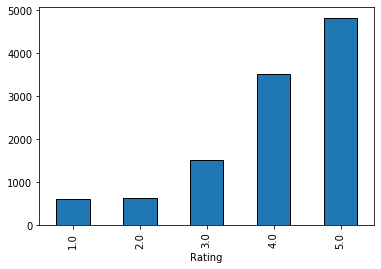

In [181]:
# Rating counts
df_small.groupby(['Rating']).size().plot.bar()
plt.show()


In [182]:
# user id review counts 
rated_products_per_user = df_small.groupby(by='UserID')['Rating'].count().sort_values(ascending=False)
print(rated_products_per_user, "\n", "\n", rated_products_per_user.describe())

UserID
A3V6Z4RCDGRC44    744
A3W4D8XOGLWUN5    475
A20DZX38KRBIT8    259
A74TA8X5YQ7NE     177
A5JLAU2ARJ0BO     132
                 ... 
A3A8ZWV1PQWXK5     10
A2IE7YPWUYZAXS     10
A3L8XRYMLZZES6     10
A26M2R0EYFM3GL     10
A3TUWNDO2728F3     10
Name: Rating, Length: 392, dtype: int64 
 
 count    392.000000
mean      28.298469
std       48.335202
min       10.000000
25%       14.000000
50%       19.000000
75%       28.000000
max      744.000000
Name: Rating, dtype: float64


Our model is going to be build and tested of around 392 users in total.

In [183]:
heavy_users = df_small.groupby(by='UserID')['Rating'].count()

In [184]:
# Top 5 Users
heavy_users.sort_values(ascending=False).head()

UserID
A3V6Z4RCDGRC44    744
A3W4D8XOGLWUN5    475
A20DZX38KRBIT8    259
A74TA8X5YQ7NE     177
A5JLAU2ARJ0BO     132
Name: Rating, dtype: int64

The result looks a bit odd. The first three users make combined around 10% of the total number of ratings there are. We don´t know if these are individuals or maybe some distributors/dealers. But even if they are, dealers normale don´t tend to rate products if they sell them further.

In [185]:
# Same but for product ids
df_small.groupby('ProductID')['Rating'].mean().sort_values(ascending=False).head()

ProductID
B01HIZF7XE    5.0
B001HBX4HC    5.0
B01HFRICLE    5.0
B001KC03ZY    5.0
B001KC03WW    5.0
Name: Rating, dtype: float64

In [186]:
#Total no of rating for product
df_small.groupby('ProductID')['Rating'].count().sort_values(ascending=False).head()

ProductID
B0009VXBAQ    26
B008H3SW4I    17
B001TYYZCA    16
B00X87MH0I    16
B004XO6V1G    15
Name: Rating, dtype: int64

The most rated product was reviewed 26 times. Even this result makes the number of ratings, the top 5 gave, more odd and supsicious.

In [187]:
ratings_mean_count = pd.DataFrame(df_small.groupby('ProductID')['Rating'].mean())

In [188]:
ratings_mean_count['rating_counts'] = pd.DataFrame(df_small.groupby('ProductID')['Rating'].count())

In [189]:
# Popularity based recom

ratings_mean_count.sort_values(by='rating_counts', ascending=False)

,Rating,rating_counts
ProductID,,
B0009VXBAQ,4.653846,26
B008H3SW4I,3.058824,17
B001TYYZCA,4.187500,16
B00X87MH0I,4.500000,16
B00F2BDP9K,4.400000,15
...,...,...
B000Q6ZLKM,4.000000,1
B000Q8UPKQ,4.000000,1
B000Q8XK30,5.000000,1


## Visualization of data

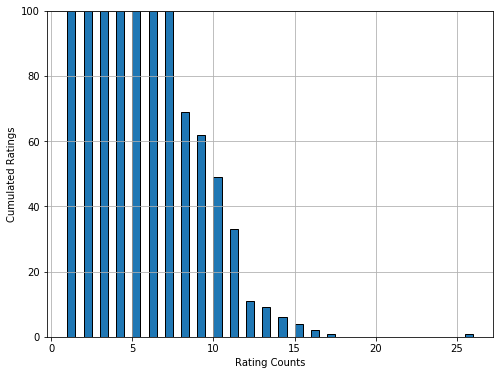

In [190]:
# Verteilung der Rating_Counts
# comment first bin 
plt.figure(figsize=(8,6))
ratings_mean_count['rating_counts'].hist(bins=50)
plt.xlabel('Rating Counts')
plt.ylabel('Cumulated Ratings')
plt.ylim(0,100)
plt.show()

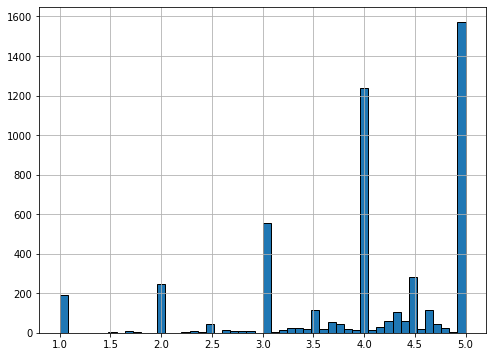

In [191]:
# Verteilung der Ratings (Histogram)
plt.figure(figsize=(8,6))
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

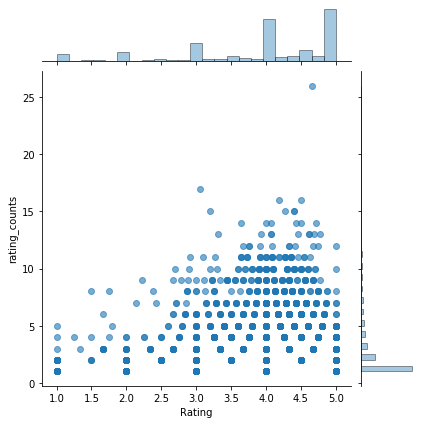

In [192]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.6)

In [193]:
most_popular_products = pd.DataFrame(df_small.groupby('ProductID')['Rating'].count()).sort_values('Rating', ascending=False).head(20)
most_popular_products

,Rating
ProductID,
B0009VXBAQ,26
B008H3SW4I,17
B001TYYZCA,16
B00X87MH0I,16
B00F2BDP9K,15
B000M17AVO,15
B00CTTEKJW,15
B004XO6V1G,15
B00JC5Y4FQ,14


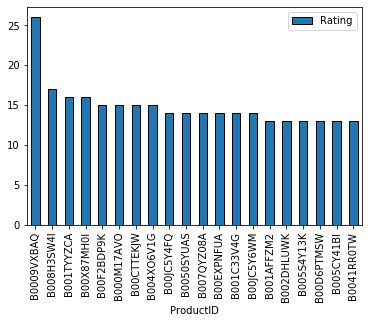

In [194]:
most_popular_products.plot.bar()

In [195]:
# Need to account for weighted average
score_matrix = ratings_mean_count.sort_values(by='rating_counts', ascending=False)
# Hyperparameter C and m 
C = score_matrix['Rating'].mean()
#Adjust for different ratings
m = score_matrix['rating_counts'].quantile(0.90)

# v = number of votes for the movie 
# m = minimum votes required to be listed in the chart
# R = average rating of the movie 
# C = mean vote across the whole report 

def weighted_rating(x, m=m, C=C):
    v = x['rating_counts']
    R = x['Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

score_matrix['score'] = score_matrix.apply(weighted_rating, axis=1)
score_matrix.sort_values('score', ascending=False)

,Rating,rating_counts,score
ProductID,,,
B00IVFDZBC,5.000000,12,4.704297
B019OB663A,5.000000,10,4.664870
B00LYYMXF6,5.000000,8,4.613311
B000B9RI14,5.000000,7,4.581087
B002BSA388,5.000000,7,4.581087
...,...,...,...
B001AYEGXM,1.666667,6,2.724823
B00452VGZW,1.000000,4,2.663672
B008U5EL5C,1.750000,8,2.613311


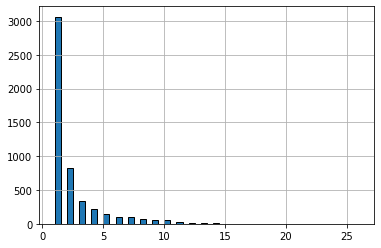

In [196]:
# Vergleich der Metriken Rating Counts, Rating und der neu gebauten Metric Score
# Als letztes dann noch Cross-Tab von jeweils zwei Metriken 

score_matrix['rating_counts'].hist(bins=50)

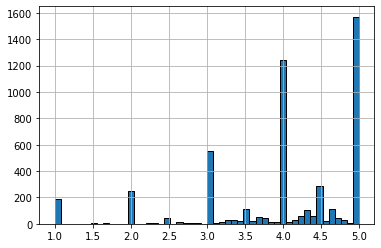

In [197]:
score_matrix['Rating'].hist(bins=50)

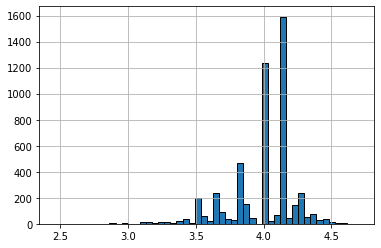

In [198]:
# Distribution of score
score_matrix['score'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

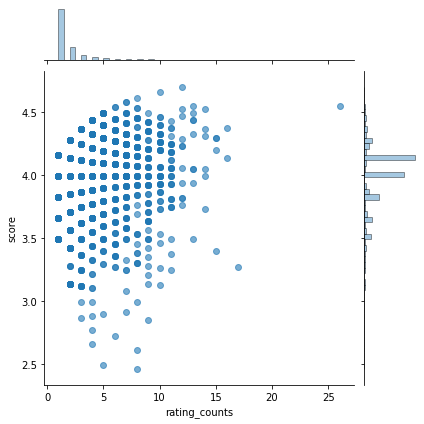

In [199]:
####### Rating counts vs Score #####################
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating_counts', y='score', data=score_matrix, alpha=0.6)

<Figure size 576x432 with 0 Axes>

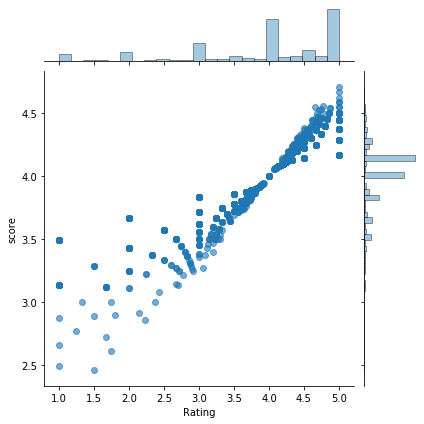

In [200]:
####### Rating vs Score #####################
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='score', data=score_matrix, alpha=0.6)

## Class - Simple Recommender

In [201]:
# Wrap it up in a class object making it reproducible


class Simple_recom():
    def __init__(self):
        self.dataframe = None
        self.user_id = None
        self.product_id = None
        self.rating = None
        self.popularity_recommendations = None

    def create(self, dataframe, user_id, product_id, rating):
        self.dataframe = dataframe
        self.user_id = user_id
        self.product_id = product_id
        self.rating = rating

        ratings_mean_count = pd.DataFrame(self.dataframe.groupby(self.product_id)[self.rating].mean())
        ratings_mean_count['rating_counts'] = pd.DataFrame(self.dataframe.groupby(self.product_id)[self.rating].count())
        ratings_mean_count.sort_values(by='rating_counts', ascending=False)

        # Need to account for weighted average
        score_matrix = ratings_mean_count.sort_values(by='rating_counts', ascending=False)
        C = score_matrix['Rating'].mean()
        m = score_matrix['rating_counts'].quantile(0.90)

        # v = number of votes for the movie
        # m = minimum votes required to be listed in the chart
        # R = average rating of the movie
        # C = mean vote across the whole report

        def weighted_rating(x, m=m, C=C):
            v = x['rating_counts']
            R = x['Rating']
            return (v/(v+m) * R) + (m/(m+v) * C)

        score_matrix['score'] = score_matrix.apply(weighted_rating, axis=1)
        score_matrix = score_matrix.reset_index()
        score_matrix_sort = score_matrix.sort_values('score', ascending=False)
        # Top 20 Products for recommendation
        score_matrix_sort['Rank'] = score_matrix_sort['score'].rank(ascending=0, method='first')
        self.popularity_recommendations = score_matrix_sort.head(10)
        return self.popularity_recommendations

    def predict(self, user_id, user_index):
        users = self.dataframe[self.user_id].unique()
        user_index = users[user_index]
        user_recommendations = self.popularity_recommendations

        #New Column for Unique User ID
        user_recommendations['user_id'] = user_index

        #Change order of columns
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]

        return user_recommendations

First, we want to look, which recommendation our simple recommender would give us on both datasets separately. Additionaly, we want to know, if the ranking would be different, if we wouldn´t have dropped out some duplicated reviews from the same product. Therefore, we´ll run our recommender on each of them serparately (cleaned and not completely cleaned datasets).

### Simple Recommender - Software - Duplicated Reviews

In [202]:
om = Simple_recom()
om.create(df_software, 'UserID', 'ProductID', 'Rating')
om.predict('UserID', 14)

,user_id,ProductID,Rating,rating_counts,score,Rank
0,A1E50L7PCVXLN4,B000050ZRE,4.927928,222,4.802049,1.0
2,A1E50L7PCVXLN4,B0001FS9NE,4.927928,222,4.802049,2.0
1,A1E50L7PCVXLN4,B000EORV8Q,4.927928,222,4.802049,3.0
10,A1E50L7PCVXLN4,B00UB76290,4.508475,59,4.269509,4.0
3,A1E50L7PCVXLN4,B00EZPXYP4,4.408163,98,4.265389,5.0
4,A1E50L7PCVXLN4,B00F8K9MZQ,4.378378,74,4.209083,6.0
23,A1E50L7PCVXLN4,B0144NYGJY,4.478261,46,4.207059,7.0
48,A1E50L7PCVXLN4,B00JC5Y6WM,4.600000,30,4.194790,8.0
9,A1E50L7PCVXLN4,B00EZQYC8G,4.365079,63,4.178745,9.0
11,A1E50L7PCVXLN4,B005S4Y13K,4.372881,59,4.175391,10.0


### Simple Recommender - Software - Cleaned

In [213]:
om = Simple_recom()
om.create(cleaned_df_software, 'UserID', 'ProductID', 'Rating')
om.predict('UserID', 14)

,user_id,ProductID,Rating,rating_counts,score,Rank
0,A1E50L7PCVXLN4,B000050ZRE,4.981735,219,4.853164,1.0
8,A1E50L7PCVXLN4,B00UB76290,4.508475,59,4.275858,2.0
1,A1E50L7PCVXLN4,B00EZPXYP4,4.408163,98,4.269691,3.0
3,A1E50L7PCVXLN4,B00F8K9MZQ,4.383562,73,4.216041,4.0
21,A1E50L7PCVXLN4,B0144NYGJY,4.478261,46,4.213691,5.0
46,A1E50L7PCVXLN4,B00JC5Y6WM,4.600000,30,4.203128,6.0
308,A1E50L7PCVXLN4,B00LYYMXF6,5.000000,14,4.183899,7.0
6,A1E50L7PCVXLN4,B00EZQYC8G,4.365079,63,4.183773,8.0
9,A1E50L7PCVXLN4,B005S4Y13K,4.379310,58,4.182796,9.0
83,A1E50L7PCVXLN4,B00MHZ71G2,4.625000,24,4.166777,10.0


We can clearly see some differences. Both place 2 and 3 went down in ranking and they lost a high amount of ratings.

### Simple Recommender - Games - Duplicated Reviews

In [214]:
om = Simple_recom()
om.create(df_games, 'UserID', 'ProductID', 'Rating')
om.predict('UserID', 14)

,user_id,ProductID,Rating,rating_counts,score,Rank
40,A15PIAQT55GNCA,B0094X227I,4.814181,409,4.733244,1.0
8,A15PIAQT55GNCA,B000B9RI14,4.761566,562,4.705434,2.0
112,A15PIAQT55GNCA,B00AKIPBNS,4.810345,290,4.702192,3.0
18,A15PIAQT55GNCA,B00N4ABT1C,4.753507,499,4.691817,4.0
5,A15PIAQT55GNCA,B00DC7G2W8,4.739703,607,4.689228,5.0
83,A15PIAQT55GNCA,B00GANWVJE,4.763473,334,4.674252,6.0
140,A15PIAQT55GNCA,B00KI2OZ9M,4.785714,266,4.673784,7.0
61,A15PIAQT55GNCA,B001JKTC9A,4.753425,365,4.672110,8.0
99,A15PIAQT55GNCA,B0053B66KE,4.770000,300,4.671231,9.0
16,A15PIAQT55GNCA,B00ZQC73O8,4.729249,506,4.670744,10.0


### Simple Recommender - Games - Cleaned 

In [215]:
om = Simple_recom()
om.create(cleaned_df_games, 'UserID', 'ProductID', 'Rating')
om.predict('UserID', 14)

,user_id,ProductID,Rating,rating_counts,score,Rank
42,A15PIAQT55GNCA,B0094X227I,4.809045,398,4.726939,1.0
8,A15PIAQT55GNCA,B000B9RI14,4.758993,556,4.702585,2.0
111,A15PIAQT55GNCA,B00AKIPBNS,4.807018,285,4.697866,3.0
5,A15PIAQT55GNCA,B00DC7G2W8,4.736667,600,4.685897,4.0
17,A15PIAQT55GNCA,B00N4ABT1C,4.747433,487,4.684984,5.0
16,A15PIAQT55GNCA,B00ZQC73O8,4.729622,503,4.670694,6.0
82,A15PIAQT55GNCA,B00GANWVJE,4.759878,329,4.669913,7.0
142,A15PIAQT55GNCA,B00KI2OZ9M,4.778210,257,4.664233,8.0
103,A15PIAQT55GNCA,B0053B66KE,4.762887,291,4.662541,9.0
29,A15PIAQT55GNCA,B00DD0B1R0,4.728311,438,4.661741,10.0


As on the other dataset, we see some differences in the ranking on the cleaned dataset compared to the uncleaned one.

### Simple Recommender - Merged - Uncleaned

In [216]:
# First, we´ll merge both datasets with duplicated reviews on each other

list_users_software = df_software["UserID"].values.tolist()  # First we´ll extract each user of the dataframe software into a list
set_users_software = set(list_users_software) # each userid only one time
filter_df_games = df_games[df_games["UserID"].isin(set_users_software)] # We´ll check on the other dataframe if these users are also there

list_filtered_users = filter_df_games["UserID"].values.tolist() # now we extract every user, that appeared on both, into a list
set_filtered_users = set(list_filtered_users) # each userid only one time
filter_df_software = df_software[df_software["UserID"].isin(set_filtered_users)] # we´ll focus only on the users, who appeared in both 

dfs_merged_with_duplicates = pd.concat([filter_df_games, filter_df_software], ignore_index = True, sort = False) # merge both datasets 

# Now we´ll run our simple recommender over that merged dataset
om = Simple_recom()
om.create(dfs_merged_with_duplicates, 'UserID', 'ProductID', 'Rating')
om.predict('UserID', 14)

,user_id,ProductID,Rating,rating_counts,score,Rank
39,A3V6Z4RCDGRC44,B00IVFDZBC,5.000000,12,4.705390,1.0
123,A3V6Z4RCDGRC44,B019OB663A,5.000000,10,4.666109,2.0
234,A3V6Z4RCDGRC44,B00LYYMXF6,5.000000,8,4.614741,3.0
313,A3V6Z4RCDGRC44,B000B9RI14,5.000000,7,4.582636,4.0
344,A3V6Z4RCDGRC44,B002BSA388,5.000000,7,4.582636,5.0
0,A3V6Z4RCDGRC44,B0009VXBAQ,4.666667,27,4.562238,6.0
17,A3V6Z4RCDGRC44,B0043SK9QU,4.769231,13,4.555090,7.0
372,A3V6Z4RCDGRC44,B000P46NKC,5.000000,6,4.544694,8.0
452,A3V6Z4RCDGRC44,B01D63UU52,5.000000,6,4.544694,9.0
439,A3V6Z4RCDGRC44,B0002XL3BA,5.000000,6,4.544694,10.0


### Simple Recommender - Merged - Cleaned

In [218]:
om = Simple_recom()
om.create(dfs_merged, 'UserID', 'ProductID', 'Rating')
om.predict('UserID', 14)

,user_id,ProductID,Rating,rating_counts,score,Rank
24,A1YK56DPXS5DFX,B00IVFDZBC,5.000000,12,4.704297,1.0
88,A1YK56DPXS5DFX,B019OB663A,5.000000,10,4.664870,2.0
194,A1YK56DPXS5DFX,B00LYYMXF6,5.000000,8,4.613311,3.0
284,A1YK56DPXS5DFX,B000B9RI14,5.000000,7,4.581087,4.0
343,A1YK56DPXS5DFX,B002BSA388,5.000000,7,4.581087,5.0
20,A1YK56DPXS5DFX,B0043SK9QU,4.769231,13,4.554058,6.0
0,A1YK56DPXS5DFX,B0009VXBAQ,4.653846,26,4.547518,7.0
458,A1YK56DPXS5DFX,B0002XL3BA,5.000000,6,4.543004,8.0
452,A1YK56DPXS5DFX,B01D63UU52,5.000000,6,4.543004,9.0
196,A1YK56DPXS5DFX,B000A6M8QI,4.875000,8,4.536388,10.0


In [219]:
# Evaluate the model's performance 
class Evaluate():
    def __init__(self):
        self.train_data = None
        self.model_1 = None
        self.model_2 = None
        
    def evaluate_pop(self, model_1):
        pass
    
    def evaluate_sim(self, model_2):
        pass

## Class - Item-based recommender

In [220]:
class Item_Sim():
    def __init__(self):
        self.df = None
        self.userid = None
        self.productid = None
        self.rating = None
        self.correlation_matrix = None
        self.X = None
        
    #Creates instance of model    
    def create_model(self, df, userid, productid, rating):
        self.df = df 
        self.userid = userid
        self.productid = productid
        self.rating = rating
        return self.df
    
    #Get unique products given userid
    def get_user_items(self, user):
        user_data = self.df[self.df[self.userid] == user]
        user_products = list(user_data[self.productid].unique())
        
        return user_products
    
    #Get items reviewed by user
    def get_item_user(self, product):
        product_data = self.df[self.df[self.productid] == product]
        product_users = set(product_data[self.userid].unique())
        
        return product_users
    

    def create_corr_matrix(self):
        #Creates pivot table (sparse matrix)
        pivot_m = self.df.groupby([self.userid, self.productid])[self.rating].max().unstack()
        
        #Fills missing values with zeros 
        pivot_m = pivot_m.fillna(value=0)
        
        # Transpose pivot table
        self.X = pivot_m.T
        
        #Decomposing the Matrix
        SVD = TruncatedSVD(n_components=10)
        decomposed_matrix = SVD.fit_transform(self.X)
        
        #Correlation Matrix
        self.correlation_matrix = np.corrcoef(decomposed_matrix)
        
        return self.correlation_matrix
    
    def show_corr_matrix(self):
        #Creates pivot table (sparse matrix)
        pivot_m = self.df.groupby([self.userid, self.productid])[self.rating].max().unstack()
        
        #Fills missing values with zeros 
        pivot_m = pivot_m.fillna(value=0)
        
        return pivot_m
    
    def recommend(self, product):
        
        product_names = list(self.X.index)
        product_ID = product_names.index(product)
        correlation_product_ID = self.correlation_matrix[product_ID]
        
        recommend = list(self.X.index[correlation_product_ID > 0.65])
        #Top 20 Recommendations
        recommend = recommend[0:19]
        
        return recommend

In [224]:
#Create smaller dataframe because of memory reasons. In production level one would need to allocate data differently
df_small_sample = df_small.head(200000)
#Initializes instance of model
km = Item_Sim()
#Creates model
km.create_model(df_small_sample, 'UserID', 'ProductID', 'Rating')
#km.get_item_user('0077613252')
# Creates correlation matrix of products
km.create_corr_matrix()
# Recommends items based on item similarity 
km.recommend('0321700945')

['0321700945',
 '0321719816',
 '0321719824',
 '0982697813',
 '1413313701',
 '1413313728',
 '1600775411',
 '1615354336',
 'B00000I1BQ',
 'B00000IWIW',
 'B00000IZ7Q',
 'B00000K2X5',
 'B00000K3QV',
 'B00000K4AX',
 'B00001NFUA',
 'B00001P4Y6',
 'B00001QER9',
 'B00001QHYE',
 'B00001SVE2']

In [225]:
#Create smaller dataframe because of memory reasons. In production level one would need to allocate data differently
df_small_sample = df_small.head(200000)
#Initializes instance of model
mm = Item_Sim()
#Creates model
mm.create_model(df_small_sample, 'UserID', 'ProductID', 'Rating')
#Show corr
mm.show_corr_matrix()

ProductID,0321700945,0321719816,0321719824,0763855553,0804161380,0982697813,1413313701,1413313728,1426296355,1600775411,...,B01H2DKHPA,B01H39M7ME,B01H3NU4OS,B01H4RS5AI,B01H6DHITE,B01H867JUM,B01HAP3NUG,B01HAP47PQ,B01HFRICLE,B01HIZF7XE
UserID,,,,,,,,,,,,,,,,,,,,,
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y058K7B96C6,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1143YEAZYMYHJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12ANFNOSMW5VD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12B0WVHZDEZL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYUF7YETYOLNX,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ515FFZ7I2P7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
AZQGJ5CEAJGXB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [226]:
### Gitintegration Test

def function_1(factor):
    i = 10 
    return i*factor

function_1(15)

150